In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
import warnings
import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import r2_score

warnings.filterwarnings('ignore')
sns.set_theme(style="whitegrid")

train_df = pd.read_csv("data/raw/train(1).csv") 

train_df['price_log'] = np.log1p(train_df['price'])
train_df['price_per_sqft'] = train_df['price'] / train_df['sqft_living']

In [2]:
coords = train_df[['lat', 'long']]

scaler = StandardScaler()
coords_scaled = scaler.fit_transform(coords)

K = 18 
kmeans = KMeans(n_clusters=K, init='k-means++', random_state=42)
train_df['neighborhood_cluster'] = kmeans.fit_predict(coords_scaled)

print(f"Successfully engineered {K} neighborhood clusters.")

Successfully engineered 18 neighborhood clusters.


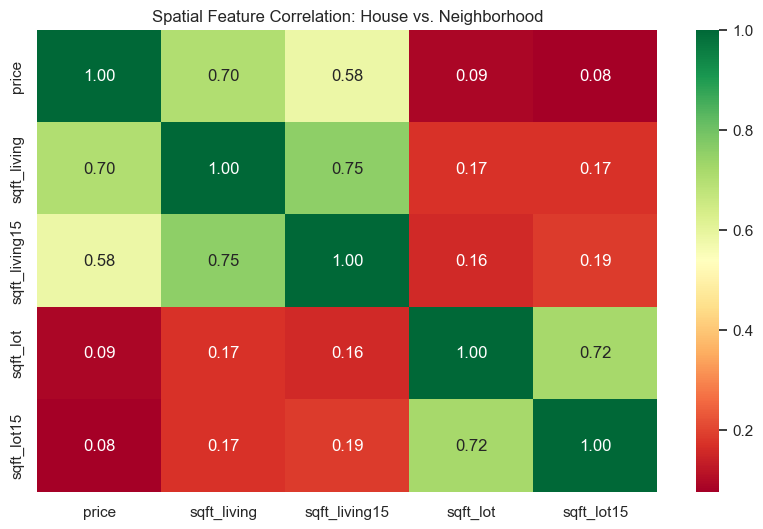

In [3]:
correlation_matrix = train_df[['price', 'sqft_living', 'sqft_living15', 'sqft_lot', 'sqft_lot15']].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='RdYlGn', fmt=".2f")
plt.title("Spatial Feature Correlation: House vs. Neighborhood")
plt.show()

train_df['size_ratio'] = train_df['sqft_living'] / train_df['sqft_living15']

In [5]:
map_center = [train_df['lat'].mean(), train_df['long'].mean()]
m = folium.Map(location=map_center, zoom_start=10, tiles='cartodbpositron')

heat_data = train_df[['lat', 'long', 'price_per_sqft']].dropna().values.tolist()

HeatMap(heat_data, radius=10, blur=15, max_zoom=1).add_to(m)

for i, center in enumerate(scaler.inverse_transform(kmeans.cluster_centers_)):
    folium.Marker(location=[center[0], center[1]], 
                  popup=f"Cluster {i}",
                  icon=folium.Icon(color='red', icon='info-sign')).add_to(m)

m.save("output/geospatial_heatmap.html")
m 

In [10]:
train_df['size_rel_neighbors'] = train_df['sqft_living'] / train_df['sqft_living15']
train_df['lot_rel_neighbors'] = train_df['sqft_lot'] / train_df['sqft_lot15']

train_df['grade_sqft'] = train_df['grade'] * train_df['sqft_living']
train_df['grade_squared'] = train_df['grade'] ** 2 

train_df['effective_yr'] = train_df['yr_renovated'].where(train_df['yr_renovated'] != 0, train_df['yr_built'])
train_df['house_age'] = 2015 - train_df['effective_yr']
train_df['total_area'] = train_df['sqft_living'] + train_df['sqft_basement']

train_df['bath_density'] = train_df['bathrooms'] / train_df['sqft_living']

In [11]:
features = [
    'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 
    'waterfront', 'view', 'condition', 'grade', 'sqft_above', 
    'sqft_basement', 'lat', 'long', 'sqft_living15', 'sqft_lot15',
    # New Features
    'size_rel_neighbors', 'lot_rel_neighbors', 'grade_sqft', 'grade_squared',
    'house_age', 'total_area', 'bath_density'
]

X = train_df[features].values
y = np.log1p(train_df['price']) # Log Target is mandatory

In [12]:
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1500,        # More trees
    learning_rate=0.01,       # Slower learning (finer convergence)
    max_depth=6,              # Standard depth
    subsample=0.7,            # Stochastic features prevent overfitting
    colsample_bytree=0.7,
    n_jobs=-1,
    random_state=42
)

In [13]:
print("Running 5-Fold Cross-Validation...")
cv = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(model, X, y, scoring='r2', cv=cv)

print(f"\n--- BASELINE SCORE ---")
print(f"Average R²: {np.mean(scores):.5f}")

Running 5-Fold Cross-Validation...

--- BASELINE SCORE ---
Average R²: 0.90182
